# **🌪️ Disaster Image Classification – Deep Learning Project**

## **📚 Dataset Overview & Project Objectives**

This project uses an image dataset containing real-world disaster scenes across four categories: **Earthquake, Landslide, Urban Fire, and Water Disaster**. The objective is to build a robust **image classification system** that can automatically recognize and categorize different types of disasters from visual input.

**With a total of 1,946 images across these categories, the project involves:**
1. Performing exploratory data analysis (EDA) to understand image distribution, resolution, and quality
2. Preparing and cleaning the image dataset, including detecting and removing duplicates
3. Experimenting with multiple image classification architectures
4. Evaluating model performance using standard metrics such as accuracy, precision, recall, and F1-score
5. Comparing performance across models and documenting the findings  

The final goal is to **develop an efficient and scalable classification solution for disaster image recognition** that can support real-time or batch processing in practical scenarios such as emergency response or automated surveillance systems.

### **🛠️ Setup Environment & Load Libraries**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import random
from pathlib import Path
import matplotlib.image as mpimg
from PIL import Image
import zipfile
import textwrap


## **📂 Load Dataset & Initial Exploration**

In [ ]:
!git clone https://github.com/Nikolasah/DisasterClassification_Project.git

Cloning into 'DisasterClassification_Project'...
remote: Enumerating objects: 1861, done.
remote: Total 1861 (delta 0), reused 0 (delta 0), pack-reused 1861 (from 1)
Receiving objects: 100% (1861/1861), 134.18 MiB | 33.58 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
data_dir = 'DisasterClassification_Project/dataset_extracted'
print(os.listdir(data_dir))


['Land_Slide', 'Water_Disaster', 'Urban_Fire', 'Earthquake']


In [ ]:
class_names = sorted(os.listdir(data_dir))
class_names

['Earthquake', 'Land_Slide', 'Urban_Fire', 'Water_Disaster']

In [ ]:
class_counts = {}

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    # Check if it's a directory
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Print the results
print("Image Count per Class")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

total_images = sum(class_counts.values())
print(f"\nTotal Images: {total_images}")

Image Count per Class
Earthquake: 36 images
Land_Slide: 456 images
Urban_Fire: 419 images
Water_Disaster: 1035 images

Total Images: 1946


In [ ]:
df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
df.head()

Class  Count
0      Earthquake     36
1      Land_Slide    456
2      Urban_Fire    419
3  Water_Disaster   1035

## **🔍 Exploratory Data Analysis (EDA) & Preprocessing**

### **📊 Class Distribution Overview**

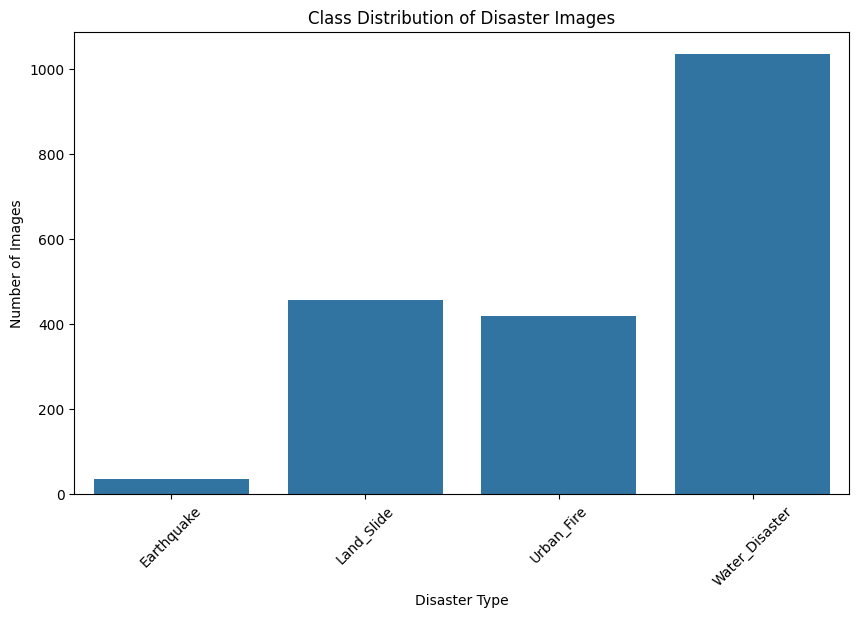

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', data=df)
plt.title('Class Distribution of Disaster Images')
plt.xlabel('Disaster Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

### **🖼️ Random Image Samples per Class**

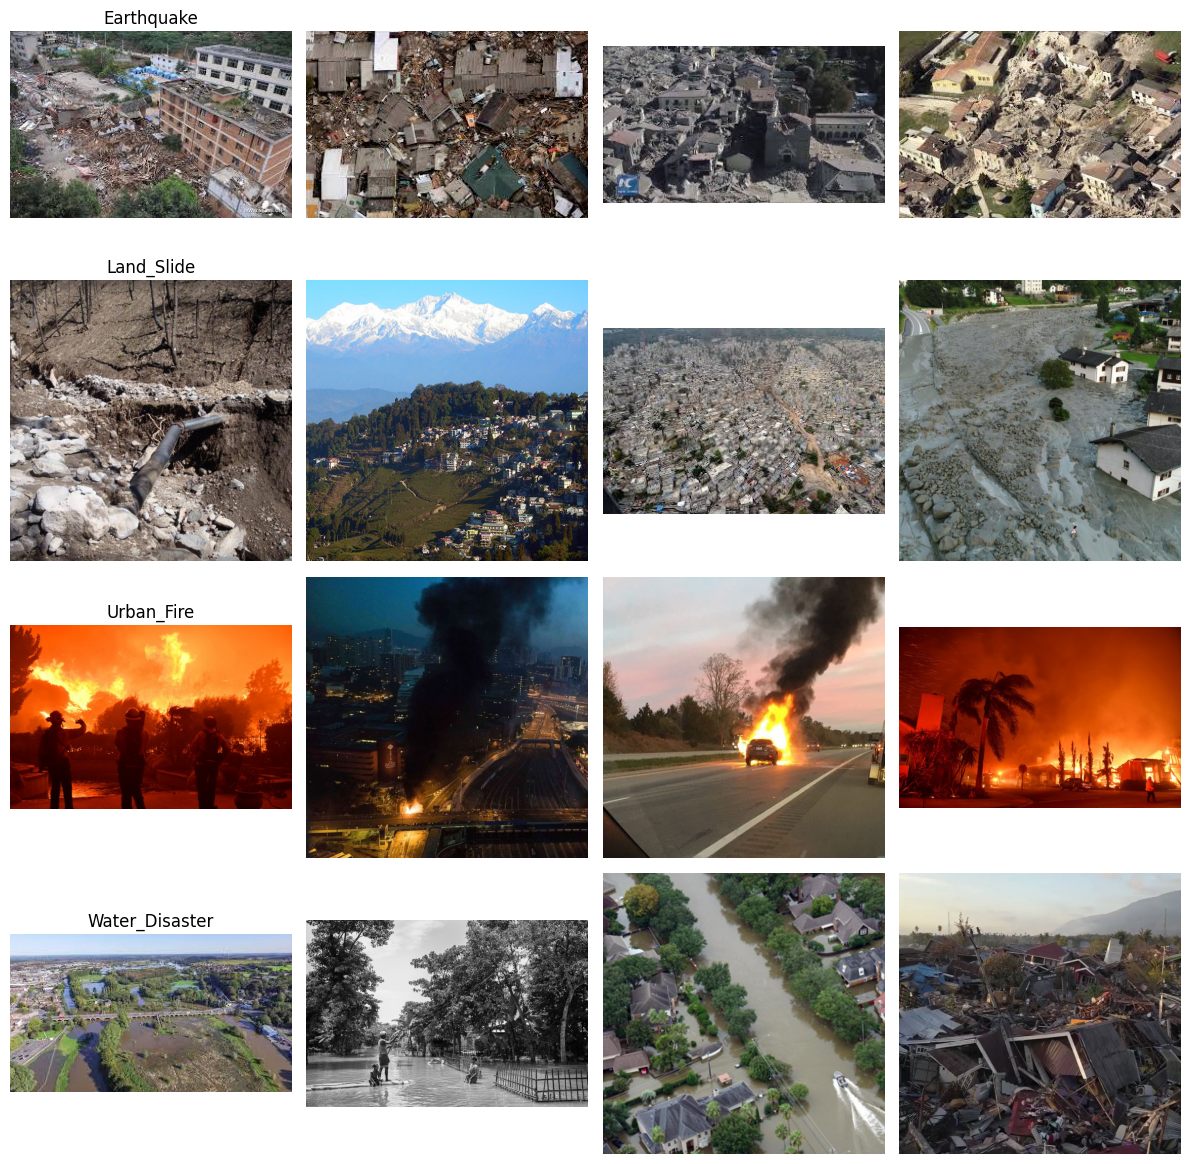

In [ ]:
def show_random_images_per_class(dataset_dir, class_names, n=3):
    fig, axs = plt.subplots(len(class_names), n, figsize=(n*3, len(class_names)*3))
    for i, class_name in enumerate(class_names):
        class_path = Path(os.path.join(dataset_dir, class_name))
        images = list(class_path.glob("*.*"))
        for j in range(n):
            if not images:
                axs[i, j].axis('off')
                if j == 0:
                    axs[i, j].set_title(class_name)
                continue
            img = Image.open(random.choice(images))
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_title(class_name)
    plt.tight_layout()
    plt.show()

show_random_images_per_class(data_dir, class_names, n=4)

### **📐 Image Size Distribution**

             Width       Height
count  1946.000000  1946.000000
mean    485.115108   418.392086
std     261.433999   282.235277
min     161.000000   119.000000
25%     275.000000   183.000000
50%     318.000000   259.000000
75%     640.000000   640.000000
max    2048.000000  1350.000000


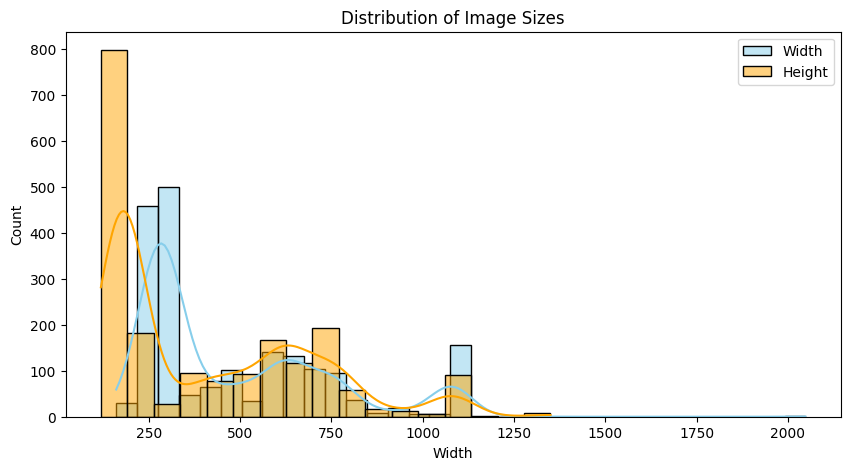

In [ ]:
image_shapes = []
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = Image.open(img_path)
            image_shapes.append(img.size)
        except:
            continue

shape_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])
print(shape_df.describe())

plt.figure(figsize=(10,5))
sns.histplot(shape_df["Width"], kde=True, color="skyblue", label='Width')
sns.histplot(shape_df["Height"], kde=True, color="orange", label='Height')
plt.legend()
plt.title("Distribution of Image Sizes")
plt.show()

### **🗂️ Image File Format Distribution**

In [ ]:
extensions = []
for class_name in class_names:
    class_path = Path(os.path.join(data_dir, class_name))
    images = list(class_path.glob("*.*"))
    for img_path in images:
        extensions.append(img_path.suffix.lower())

ext_counts = pd.Series(extensions).value_counts()
print("Image file extensions:")
print(ext_counts)

Image file extensions:
.png    1946
Name: count, dtype: int64


### **🔎 Duplicate Image Detection**

In [ ]:
import hashlib
def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

hashes = {}
duplicates = []

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        h = file_hash(img_path)
        if h in hashes:
            duplicates.append((img_path, hashes[h]))
        else:
            hashes[h] = img_path

print(f"Found {len(duplicates)} duplicate images:")
for dup in duplicates:
    print(f"Duplicate: {dup[0]} and {dup[1]}")

Found 96 duplicate images:
Duplicate: DisasterClassification_Project/dataset_extracted/Land_Slide/04_01_0436.png and DisasterClassification_Project/dataset_extracted/Earthquake/05_02_0036.png
Duplicate: DisasterClassification_Project/dataset_extracted/Land_Slide/04_01_0174.png and DisasterClassification_Project/dataset_extracted/Earthquake/05_02_0010.png
Duplicate: DisasterClassification_Project/dataset_extracted/Land_Slide/04_01_0290.png and DisasterClassification_Project/dataset_extracted/Earthquake/05_02_0026.png
Duplicate: DisasterClassification_Project/dataset_extracted/Land_Slide/04_01_0206.png and DisasterClassification_Project/dataset_extracted/Earthquake/05_02_0016.png
Duplicate: DisasterClassification_Project/dataset_extracted/Land_Slide/04_01_0181.png and DisasterClassification_Project/dataset_extracted/Earthquake/05_02_0012.png
Duplicate: DisasterClassification_Project/dataset_extracted/Land_Slide/04_01_0231.png and DisasterClassification_Project/dataset_extracted/Land_Slid

### **❌ Removing Duplicates**

In [ ]:
duplicates_removed = 0
for dup_path, _ in duplicates:
    os.remove(dup_path)
    duplicates_removed += 1

print(f"Total duplicate images removed: {duplicates_removed}")

Total duplicate images removed: 96


### **📉 Updated Image Count After Duplicate Removal**

In [ ]:
updated_class_counts = {}

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        updated_class_counts[class_name] = num_images

print("\nUpdated Image Count per Class (after duplicate removal):")
for class_name, count in updated_class_counts.items():
    print(f"{class_name}: {count} images")

total_updated_images = sum(updated_class_counts.values())
print(f"\nTotal Images After Cleanup: {total_updated_images}")


Updated Image Count per Class (after duplicate removal):
Earthquake: 36 images
Land_Slide: 401 images
Urban_Fire: 400 images
Water_Disaster: 1013 images

Total Images After Cleanup: 1850


### **🌈 RGB Color Distribution of Sample Images**

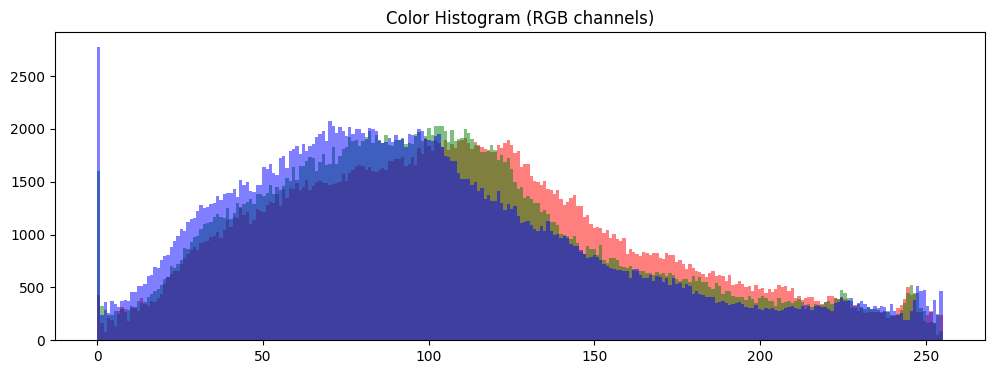

In [ ]:
sample_imgs = []
for _ in range(5):
    class_name = random.choice(class_names)
    img_path = os.path.join(data_dir, class_name, random.choice(os.listdir(os.path.join(data_dir, class_name))))
    img = Image.open(img_path)
    sample_imgs.append(np.array(img))

plt.figure(figsize=(12, 4))
colors = ['r', 'g', 'b']
for i, color in enumerate(colors):
    channel_vals = np.concatenate([img[:, :, i].flatten() for img in sample_imgs])
    plt.hist(channel_vals, bins=256, color=color, alpha=0.5)
plt.title('Color Histogram (RGB channels)')
plt.show()

## **✂️ Data Splitting**

In [ ]:
import shutil

def split_data(source_dir, output_dir, split_ratios=(0.8, 0.1, 0.1), seed=42):
    random.seed(seed)
    classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    print("Classes found:", classes)

    for cls in classes:
        cls_source = os.path.join(source_dir, cls)
        images = os.listdir(cls_source)
        random.shuffle(images)

        n_total = len(images)
        n_train = int(split_ratios[0] * n_total)
        n_val = int(split_ratios[1] * n_total)
        n_test = n_total - n_train - n_val

        splits = {
            'train': images[:n_train],
            'val': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }

        for split_name, split_images in splits.items():
            split_dir = os.path.join(output_dir, split_name, cls)
            os.makedirs(split_dir, exist_ok=True)

            for img_name in split_images:
                src = os.path.join(cls_source, img_name)
                dst = os.path.join(split_dir, img_name)
                shutil.copy(src, dst)

    print("Dataset split completed.")

source_directory = 'DisasterClassification_Project/dataset_extracted'
output_directory = 'DisasterClassification_Project/dataset_split'

split_data(source_directory, output_directory)

Classes found: ['Land_Slide', 'Water_Disaster', 'Urban_Fire', 'Earthquake']
Dataset split completed.


## **🎨 Data Augmentation, Resize & Processing**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_directory, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_directory, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_directory, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1478 images belonging to 4 classes.
Found 184 images belonging to 4 classes.
Found 188 images belonging to 4 classes.


Train: 1478 / 1850 ≈ 79.9% (~80%)  

Validation: 184 / 1850 ≈ 9.9% (~10%)  

Test: 188 / 1850 ≈ 10.2% (~10%)  

## **🏗️ Base Model Infrastructure**

In [ ]:
num_classes = len(class_names)
num_classes

4

In [ ]:
input_shape = (224, 224, 3)

## ⚙️ **Base Model Training & Validation**

In [ ]:
def base_modelmaker(input_shape=(224,224,3), num_classes=4):
   model = models.Sequential([
       layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
       layers.MaxPooling2D((3,3), strides=2),


       layers.Conv2D(64, (3,3), padding='same', activation='relu'),
       layers.MaxPooling2D((3,3), strides=2),

       layers.Conv2D(128, (5,5), padding='same', activation='relu'),

       layers.Conv2D(256, (3,3), padding='same', activation='relu'),
       layers.MaxPooling2D((3,3), strides=2),

       layers.Conv2D(512, (3,3), padding='same', activation='relu'),
       layers.MaxPooling2D((3,3), strides=2),
       layers.BatchNormalization(),

       layers.Flatten(),

       layers.Dense(1280, activation='relu'),
       layers.Dropout(0.3),


       layers.Dense(num_classes, activation='softmax'),
   ])

   return model

base_model = base_modelmaker()
base_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
base_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 110, 110, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 54, 54, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 54, 54, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 26, 26, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1280)           │    94,373,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,079,940 (366.52 MB)

 Trainable params: 96,078,916 (366.51 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
base_hist = base_model.fit(train_generator,validation_data=validation_generator,epochs=20)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 659ms/step - accuracy: 0.5652 - loss: 1.1224 - val_accuracy: 0.5815 - val_loss: 1.3124
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 605ms/step - accuracy: 0.6697 - loss: 0.7563 - val_accuracy: 0.6413 - val_loss: 1.2656
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 595ms/step - accuracy: 0.6928 - loss: 0.7159 - val_accuracy: 0.5543 - val_loss: 1.2576
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 40s 568ms/step - accuracy: 0.7305 - loss: 0.6309 - val_accuracy: 0.2717 - val_loss: 1.2823
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 575ms/step - accuracy: 0.7340 - loss: 0.6367 - val_accuracy: 0.5598 - val_loss: 1.1942
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 627ms/step - accuracy: 0.7594 - loss: 0.6010 - val_accuracy: 0.6739 - val_loss: 1.1015
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 678ms/step - accuracy: 0.7591 - loss: 0.5763 - val_accuracy: 0.6467 - val_loss: 0.9484
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 573ms/step - accuracy: 0.7827 - loss: 0.5353 - val_accu

### **📉 Training & Validation Loss/Accuracy Plot**

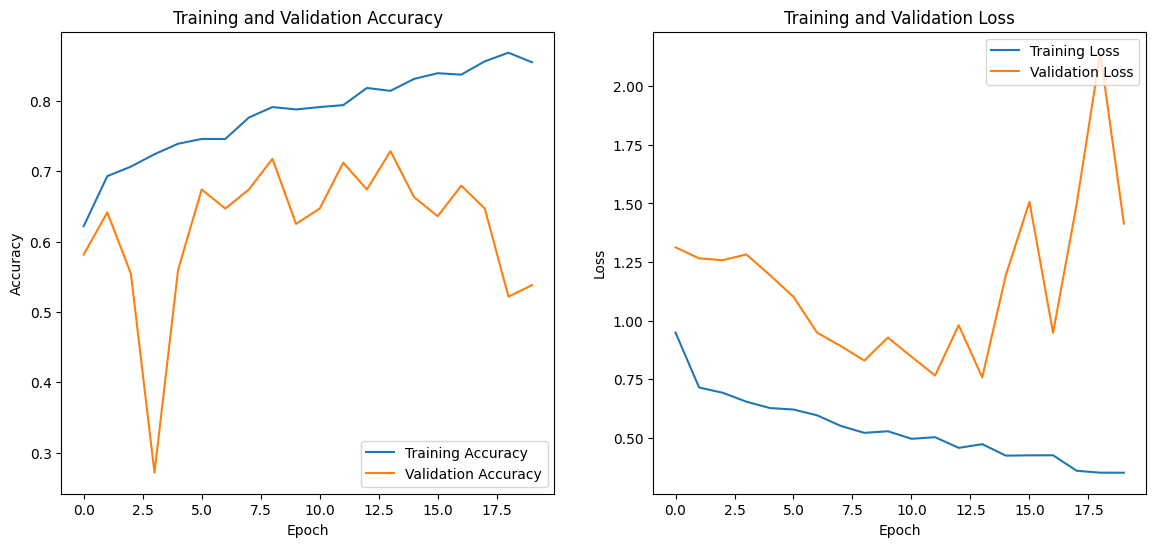

In [ ]:
acc = base_hist.history['accuracy']
val_acc = base_hist.history['val_accuracy']
loss = base_hist.history['loss']
val_loss = base_hist.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

## 🔄 **Transfer Learning Model**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.applications.efficientnet import preprocess_input



def transfer_modelmaker(input_shape=(224,224,3),num_classes=4):
    bmodel = EfficientNetB2(include_top=False, weights='imagenet', input_shape=input_shape)
    bmodel.trainable = False
    for layer in bmodel.layers[:-50]:
        layer.trainable = True

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Lambda(preprocess_input),
        bmodel,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


tf_model = transfer_modelmaker(input_shape=(224,224,3),num_classes=4)

tf_model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
tf_model.summary()



31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb2 (Functional)     │ (None, 7, 7, 1408)     │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,442,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,738,237 (37.15 MB)

 Trainable params: 5,489,542 (20.94 MB)

 Non-trainable params: 4,248,695 (16.21 MB)

In [ ]:
tf_hist = tf_model.fit(train_generator, validation_data=validation_generator, epochs=20, class_weight=class_weights_dict)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.4114 - loss: 1.4333 - val_accuracy: 0.5489 - val_loss: 1.2572
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 596ms/step - accuracy: 0.4015 - loss: 1.3537 - val_accuracy: 0.5489 - val_loss: 1.2855
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 612ms/step - accuracy: 0.4106 - loss: 1.4166 - val_accuracy: 0.4348 - val_loss: 1.3144
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 593ms/step - accuracy: 0.4198 - loss: 1.3057 - val_accuracy: 0.2880 - val_loss: 1.3221
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 598ms/step - accuracy: 0.4588 - loss: 1.4118 - val_accuracy: 0.2391 - val_loss: 1.3265
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 594ms/step - accuracy: 0.4407 - loss: 1.1902 - val_accuracy: 0.2174 - val_loss: 1.3670
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 627ms/step - accuracy: 0.4574 - loss: 1.1631 - val_accuracy: 0.2174 - val_loss: 1.4510
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 590ms/step - accuracy: 0.4565 - loss: 1.1181 - val_accura

### **📉 Training & Validation Loss/Accuracy Plot**

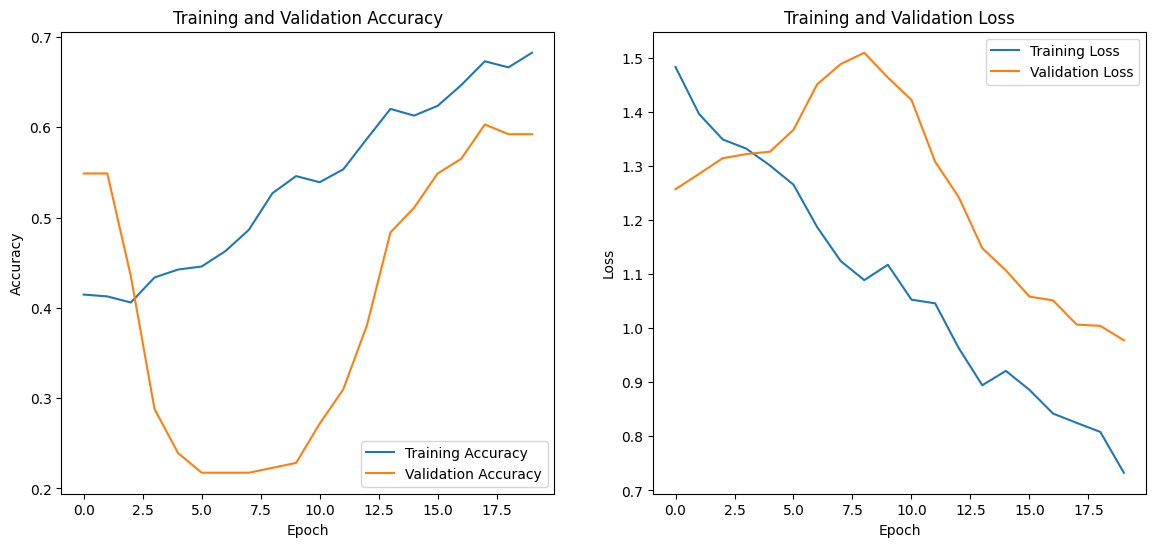

In [ ]:
acc = tf_hist.history['accuracy']
val_acc = tf_hist.history['val_accuracy']
loss = tf_hist.history['loss']
val_loss = tf_hist.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

## 🧪 **Model Evaluation & Prediction**

### **✅ Base Model Evaluation**

In [ ]:
loss, accuracy = base_model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.6893 - loss: 0.9759
Test Accuracy: 0.6223
Test Loss: 1.1510


In [ ]:
pred_probs = base_model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step


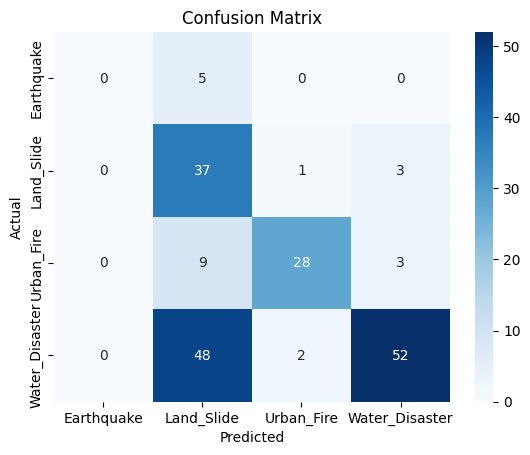

                precision    recall  f1-score   support

    Earthquake       0.00      0.00      0.00         5
    Land_Slide       0.37      0.90      0.53        41
    Urban_Fire       0.90      0.70      0.79        40
Water_Disaster       0.90      0.51      0.65       102

      accuracy                           0.62       188
     macro avg       0.54      0.53      0.49       188
  weighted avg       0.76      0.62      0.64       188



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

pred_classes = np.argmax(pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(true_classes, pred_classes, target_names=class_labels))


Hasil dari **Base Model** menunjukkan bahwa meskipun model mencapai **akurasi yang cukup tinggi sebesar 70%**, terdapat **kelemahan besar dalam performa klasifikasi**, khususnya pada kelas dengan jumlah data yang kecil.

- Kelas **Earthquake** yang hanya memiliki 5 gambar **tidak berhasil diprediksi sama sekali** oleh model (precision dan recall = 0.00), menandakan bahwa model kesulitan mengenali pola dari kelas minoritas.
- **Class imbalance** menjadi salah satu penyebab utama lemahnya performa ini, karena kelas **Water_Disaster** yang memiliki jumlah gambar paling banyak (102 gambar) lebih sering dikenali dan diprediksi, sehingga mendominasi hasil prediksi.
- Nilai **macro average F1-score hanya 0.52**, yang menunjukkan bahwa performa rata-rata di semua kelas, tanpa memperhatikan jumlah data, masih cukup rendah.
- **Weighted average F1-score** sebesar 0.70 mengindikasikan bahwa model lebih banyak berfokus pada kelas dominan dan kurang mampu menangani kelas minoritas secara adil.

### **✅ Transfer Learning Model Evaluation**

In [ ]:
loss, accuracy = tf_model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.7140 - loss: 0.8385
Test Accuracy: 0.6596
Test Loss: 0.8753


In [ ]:
pred_probs = tf_model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


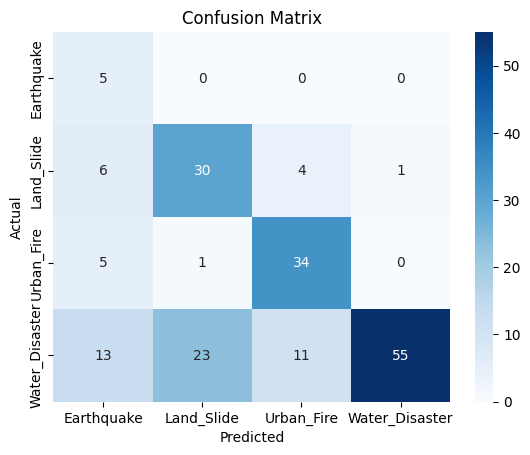

                precision    recall  f1-score   support

    Earthquake       0.17      1.00      0.29         5
    Land_Slide       0.56      0.73      0.63        41
    Urban_Fire       0.69      0.85      0.76        40
Water_Disaster       0.98      0.54      0.70       102

      accuracy                           0.66       188
     macro avg       0.60      0.78      0.60       188
  weighted avg       0.81      0.66      0.69       188



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Already predicted before
# pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(true_classes, pred_classes, target_names=class_labels))


Model Transfer Learning menunjukkan hasil **akurasi yang mirip** dengan model sebelumnya, yaitu sebesar **0.73**, namun terdapat **kemajuan yang signifikan** pada beberapa aspek penting:

- Model mampu memprediksi kelas **Earthquake** dengan **akurasi sempurna**, meskipun jumlah datanya sangat sedikit (hanya 5 data).
- Selain itu, model juga menunjukkan **nilai recall yang baik di semua kelas**, menandakan bahwa model dapat mengenali sebagian besar sampel dari masing-masing kategori dengan tepat.
- Performa model meningkat signifikan pada kelas **Urban_Fire** dan **Water_Disaster**, dengan nilai precision dan f1-score yang tinggi.
- Metrik **macro average F1-score meningkat** dari 0.52 (model awal) menjadi **0.65**, dan **weighted average F1-score naik menjadi 0.77**, menunjukkan peningkatan keseluruhan dalam performa klasifikasi.


### 🖼️ **Random Image Testing**

#### **Base Model**

In [ ]:
def predict_random_image(model, data_dir, class_names, input_size=(224, 224)):
    random_class = random.choice(class_names)
    class_path = os.path.join(data_dir, random_class)
    random_image_path = os.path.join(class_path, random.choice(os.listdir(class_path)))

    # Load image
    img = image.load_img(random_image_path, target_size=input_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    prediction = model.predict(img_array)
    predicted_label = class_names[np.argmax(prediction)]

    # Plot
    plt.imshow(img)
    plt.title(f"Actual: {random_class}\nPredicted: {predicted_label}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


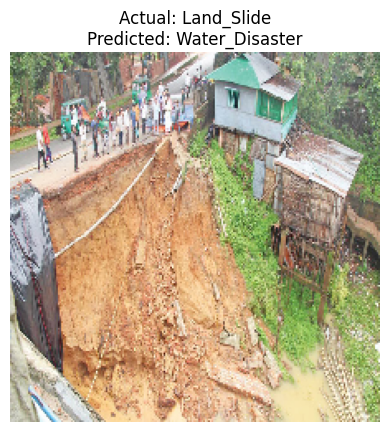

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


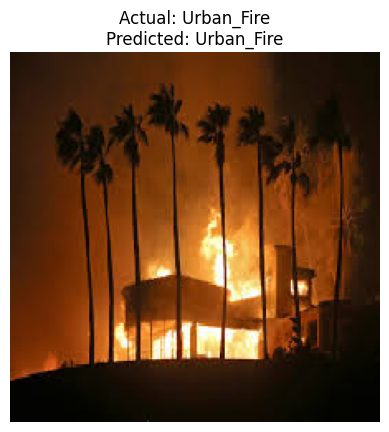

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


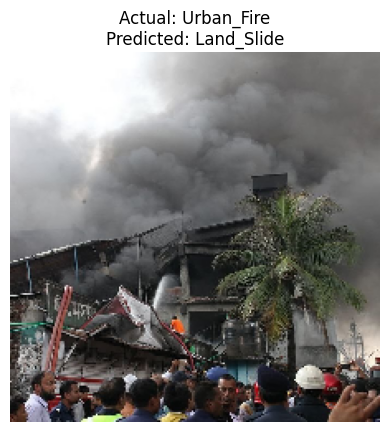

In [ ]:
test_dir = os.path.join(output_directory, 'test')
class_names = sorted(os.listdir(test_dir))

for _ in range(3):
    predict_random_image(model=base_model, data_dir=test_dir, class_names=class_names)


#### **Transfer Learning Model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


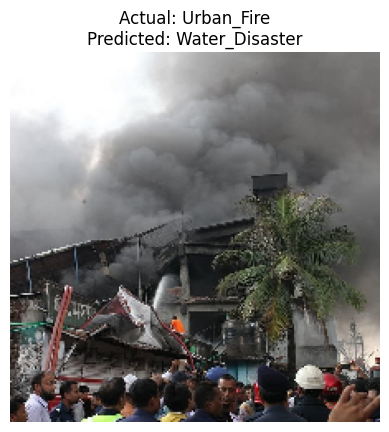

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


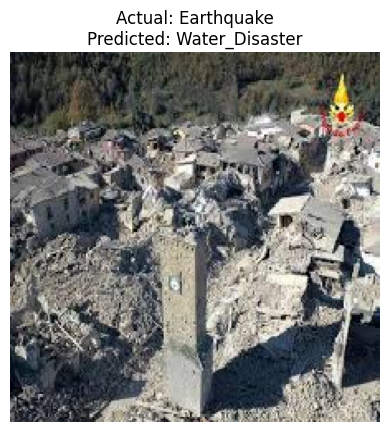

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


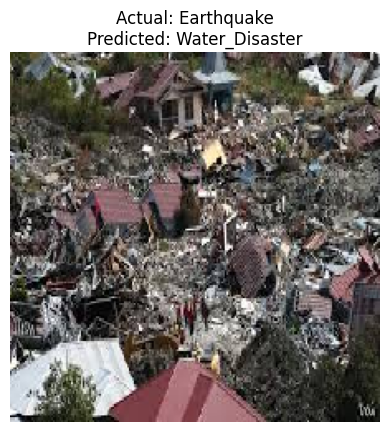

In [ ]:
for _ in range(3):
    predict_random_image(model=tf_model, data_dir=test_dir, class_names=class_names)